# Notebook for Decomposing High-Density Surface EMG

## Installing Library for Interactive Plots

You should run the code cell below to enable interactive plots. If you run it, you must wait until the runtime restarts, as we are installing a library (`ipympl`). Afterward, you can execute all other cells.

Note: "Run all" cells won't be executed successfully because the code `os.kill(os.getpid(), 9)` restarts the runtime.

If you don't need interactive plots, you can comment or delete the first code cell. Additionally, you should do the same for the commands `%matplotlib widget` and `output.enable_custom_widget_manager()` in the second code cell. If you make these changes, the "Run all" option will work correctly.

To improve visualization, all Python methods have been omitted. If you wish to explore further, you can access the files located in the dependencies folder.

In [1]:
import os
!pip install ipympl
os.kill(os.getpid(), 9)

## Cloning the GitHub Repository and Importing Libraries

In [2]:
# Identifying if the code is running on Google Colab
if 'google.colab' in str(get_ipython()):
    !git clone -l -s https://github.com/MateusASchneiderCastilhos/EMG_Crosstalk_Decomposition_Workshop cloned-repo
    %cd cloned-repo

from dependencies import utilities as util
from dependencies.widgets import decompWidgets
from dependencies.decompPanel import Decomposition

# Enabling interactive graphs plots
from google.colab import output
%matplotlib widget
output.enable_custom_widget_manager()

# Defining some default configurations to plot the graphs
util.config_plots()

## Importing HD sEMG Files and Identifying Bad Channels

### Importing HD sEMG File

The `import_Mat_file()` function is responsible for importing HD sEMG signals saved as `.mat` files. Below are some considerations about the expected structure of the data for this function to work.

The `.mat` file must be saved as a dictionary, as shown below. While there can be additional keys and values in this dictionary, the main keys are expressed here. Inside the list corresponding to the "Data" key, there is a matrix representing the HD sEMG data. Ideally, the rows of this matrix should represent EMG channels, and the columns should represent the sampled data. However, if this is not the case, the `import_Mat_file()` function can identify the orientation of the matrix and reshape it accordingly. The function provides information about the sampling frequency, time, and EMG samples.

```python
{
    "SamplingFrequency": [2048],
    "Time": [[0.0, 0.1, ..., 50]],
    "Data": [[
                [0.2, 1.0, ..., 38.2],
                [-0.5, -5.0, ..., 70.6],
                ...,
                [1.3, 5.6, ..., -54.8]
            ]]
}
```

We will import the HD sEMG signals stored in the data directory. To change the selected file, go to `util.import_Mat_file` and replace `EMG_S1_05.mat` with the actual file name.

In [3]:
# Importing EMG data, time samples and sampling frequency
f_sampling, time_samples, sEMG = util.import_Mat_file("EMG and Force Data/WorkshopData/EMG_S1_05.mat")
# Initializing the decomposition class
decomposition = Decomposition(sEMG=sEMG, time_samples=time_samples, f_sampling=f_sampling)

### Identifying Bad Channels (Visually)

Here, you will visualize the plotted HD sEMG signals and have the ability to deselect channels considered "bad" due to motion artifacts. Only the selected channels will be considered in the decomposition processing. Below, we are displaying checkboxes in a spatial format matching the electrode matrix used to record the HD sEMG signals.

**Instructions:**
1. Run the code cell below to display the grid of checkboxes and the plot of the HD sEMG signals.
2. Identify any bad channels from the graph, i.e., channels that exhibit motion artifacts. There may be several or none.
3. To mark a channel as bad, click the checkbox corresponding to that channel.
4. Any unchecked checkboxes are considered bad channels and will not be included during the decomposition process.

The selected checkboxes can be updated at any time. For example, if you notice that channels 49, 50, and 59 are not suitable after decomposing the HD sEMG, you can return to this section, unselect these channels, and rerun the decomposition in the [**Decomposition Menu**](#scrollTo=decomposition_menu) section.

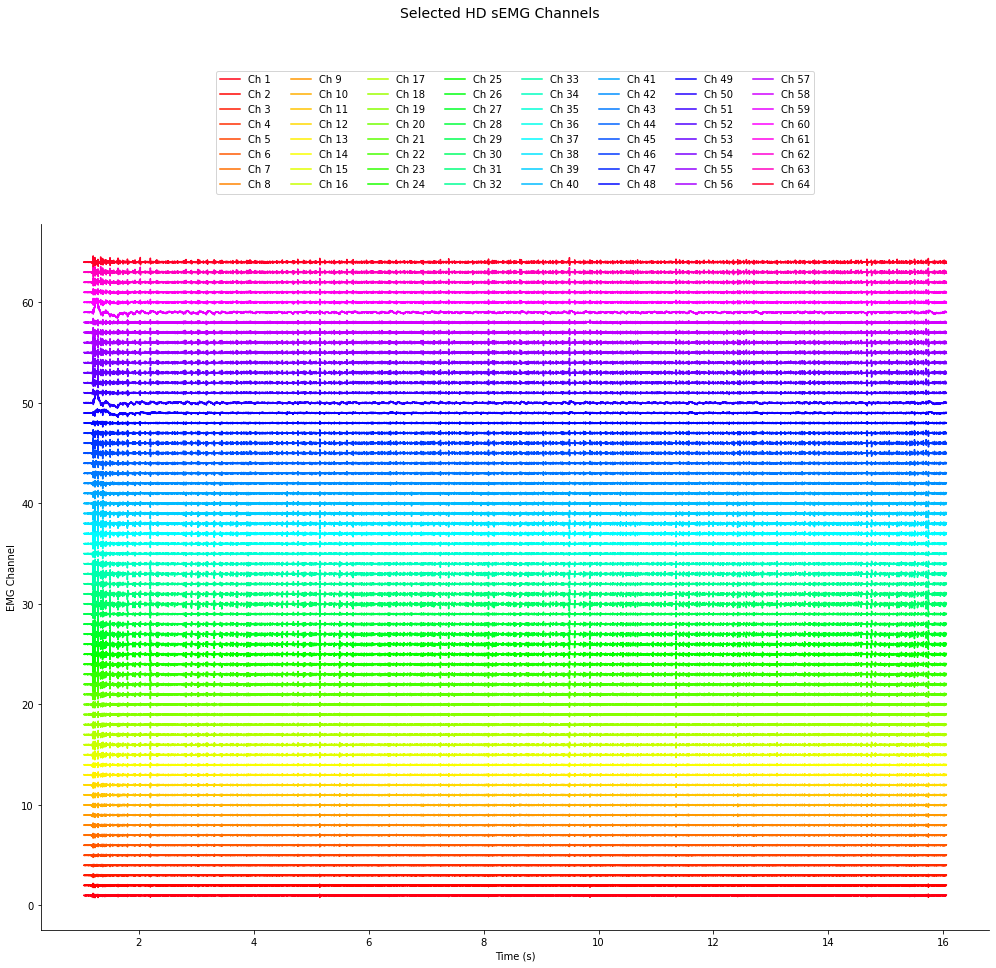

In [4]:
# Creating checkboxes for channel selection and plotting the EMG signals
widgets = decompWidgets()
choosed_channels = widgets.channels_selection(decomposition.def_grid())
decomposition.plot_channels(choosed_channels)

## Pre-processing and Decomposing the HD sEMG Signals

The FastICA-based decomposition algorithm implemented in this notebook was primarily based on [(NEGRO et al., 2016)](#scrollTo=references). There are several steps that must be completed before decomposing the HD sEMG signals, listed below. Also, refer to [Figure 1](#figure_1) for a better understanding of the flow of the algorithm.

1. Identify and remove bad channels.
2. Extend the HD sEMG signals by a constant factor of $R$.
3. Center the extended HD sEMG signals.
4. Whiten the extended HD sEMG signals.
5. Define the parameters of the decomposition algorithm, namely, *Number of Iterations (M)*, *Extension Factor (R)*, *Internal Loop Number of Iterations*, *FastICA Convergence*, and *Silhouette (SIL) Threshold*.
6. Choose a contrast function for the FastICA algorithm.
7. Choose the starting point of the FastICA algorithm.
8. Decompose the HD sEMG signals using FastICA.

If you don't rember about the Whithening pre-processing and the FastICA algorithm, you can return to the [Decomposition Workshop](https://colab.research.google.com/github/MateusASchneiderCastilhos/EMG_Crosstalk_Decomposition_Workshop/blob/main/EMG_Crosstalk_Decomposition_Workshop.ipynb).

<a name='figure_1'></a>
<figure align="center"><img src="https://github.com/MateusASchneiderCastilhos/EMG_Crosstalk_Decomposition_Workshop/blob/main/assets/Algorithm_Flowchart.png?raw=1" width="500"/><figcaption align="center"> Figure 1 - Representation of the flow of the decomposition algorithm implemented in this notebook.</figcaption></figure>

**Removing Bad Channels**

It is a common practice among decomposition experts to remove channels considered "bad." For instance, bad channels include HD sEMG signals containing significant motion artifacts and null signals due to electrode displacement. These signals can introduce errors in the estimation of motor unit spike trains.

**The Extension Procedure**

The extension of the HD sEMG signals [(NEGRO et al., 2016; HOLOBAR, ZAZULA, 2007)]((#scrollTo=references)) is a strategy to increase the number of observations and, theoretically, the number of estimated sources. This is an estrategy to make the blind source separation problem less underdetermined. This process generates $R$ versions of each HD sEMG signal, with delays ranging from 1 to $R$. Refer to [Figure 2](#figure_2) for a better understanding.

<a name='figure_2'></a>
<figure align="center"><img src="https://github.com/MateusASchneiderCastilhos/EMG_Crosstalk_Decomposition_Workshop/blob/main/assets/Extension.png?raw=1" width="500"/><figcaption align="center"> Figure 2 - Representation of the extension procedure (an exaggerated representation for didactic purposes).</figcaption></figure>

**Centering and Whitening**

After the extension procedure, centering and whitening are performed, following the recommendations of [HYVÄRINEN (1999)](#scrollTo=references), as detailed in Equations (3) and (7), respectively, in the [Decomposition Workshop](https://colab.research.google.com/github/MateusASchneiderCastilhos/EMG_Crosstalk_Decomposition_Workshop/blob/main/EMG_Crosstalk_Decomposition_Workshop.ipynb).

**Parameters of the Decomposition Algorithm**

- *Number of Iterations (M)*: The number of iterations of the FastICA algorithm. In each iteration, the algorithm attempts to estimate one spike train.

- *Extension Factor (R)*: The number of delayed HD sEMG channels. For example, if we have 64 EMG channels and R=8, there will be 512 delayed versions and 64 original versions, resulting in a total of 576 EMG signals.

- *Internal Loop Number of Iterations*: The maximum limit for the number of iterations for internal loop optimization. This parameter is needed to avoid an infinite loop.

- *FastICA Convergence*: The internal loop optimization will finish when FastICA achieves this convergence threshold.

- *Silhouette (SIL) Threshold*: According to [(NEGRO, et al., 2016)](#scrollTo=references), this threshold determines whether the quality of the estimated MU spike train is considered great or not.

**Defining the Contrast Functions**

Here, we define five distinct contrast functions for use in the decomposition process. These functions serve as cost functions employed to compute the approximate negentropy. The defined functions are expressed below. It's important to note that the algorithm utilizes their first and second derivatives. Equation (1) was suggested in [(NEGRO et al., 2016)](#scrollTo=references), equation (3) in [(HOLOBAR; ZAZULA, 2008)](#scrollTo=references), and equations (2), (4), and (5) were suggested in [(HYVÄRINEN, 1999)](#scrollTo=references).

$$ G(x) = \frac{x^3}{3} \quad (1) $$

$$ G(x) = \frac{x^4}{4} \quad (2) $$

$$ G(x) = x \text{ } ln(x^2 + 1) + 2 [tan^{-1}(x) - x] \quad (3)$$

$$ G(x) = ln(cosh(x)) \quad (4) $$

$$ G(x) = exp \Big( \frac{- x^2}{2} \Big) \quad (5) $$

**Start Point of the FastICA Algorithm**

[HOLOBAR and ZAZULA (2007)](#scrollTo=references) introduced a term namely *activity index*, which is a global indicator of motor unit discharge activity. The study by [NEGRO et al. (2016)](#scrollTo=references) suggests setting the start point of the FastICA algorithm based on this activity index. Thus, the present algorithm offers four possible initial start points based on the activity index, as follows:

1. Based on the **argument** of the activity index that corresponds to its **maximum** value. This choice was made considering the study by [NEGRO et al. (2016)](#scrollTo=references).

2. Based on the **argument** of the activity index that corresponds to its **median** value. This choice was made considering the study by [HOLOBAR and ZAZULA (2007)](#scrollTo=references).

3. Based on the **argument** of the activity index that corresponds to its **81st percentile** value. This choice was made based on some previous decompositions we conducted (data not published).

4. Based on the **argument** of the activity index that corresponds to a **random percentile** value. This choice was made as an alternative to the study by [HYVÄRINEN (1999)](#scrollTo=references), which suggests just a random initialization not based on some indicator.

### Decomposition Menu

Here we created an interactive menu of widgets for you to choose the parameters of the FastICA algorithm. After setting the parameters, the widget block passes all the parameter values to just one function responsible for: remove the bad channels, extend the HD sEMG signals by R, center the signals, whitening and decomposing the HD sEMG sigals.

If you want to unselect some HD sEMG channels, return to the [**Identifying Bad Channels (Visually)**](#scrollTo=identifying_bad_channels_(visually)) section.

In [5]:
# Creating menu for chossing the FastICA parameters
widgets.decomposition_menu(decomposition)

interactive(children=(BoundedIntText(value=120, description='Number of Iterations (M) [1 - 640]: ', max=640, m…

## Post-processing and Statistical Metrics

### Calculating Statistics and Removing Repeated Sources

After the decomposition process, some post-processing and analysis should be done. For example, we need to verify if there are repeated source signals. If it is true, we need to remove them. Moreover, we need to calculate some statistics of the interspike intervals (ISI) for each estimated source, such as the mean, standard deviation, coefficient of variation (CoV), skewness, and kurtosis. These metrics are important for experts to draw conclusions about the discharge characteristics.

In [6]:
# Getting some statistics of the spike trains
CoV, Mean, Std, Skewness, Kurtosis = decomposition.compute_PTs_statistics()
decomposition.display_statistics(CoV, Mean, Std, Skewness, Kurtosis)

MU     CoV (%)        Mean (ms)        Std (ms)        Skewness        Kurtosis  
1	0.000     	0.000     	0.000     	0.000     	0.000     
2	0.000     	0.000     	0.000     	0.000     	0.000     
3	0.000     	0.000     	0.000     	0.000     	0.000     
4	97.443    	214.738   	209.247   	2.540     	6.515     
5	38.471    	69.421    	26.707    	1.619     	4.938     
6	0.000     	0.000     	0.000     	0.000     	0.000     
7	32.046    	85.852    	27.512    	0.864     	3.798     
8	102.035   	213.549   	217.894   	2.751     	8.150     
9	97.979    	213.768   	209.448   	2.538     	6.528     
10	24.144    	84.073    	20.298    	-0.320    	3.168     
11	47.493    	72.764    	34.557    	2.712     	10.874    


### Decomposition Quality Measures

During the decomposition process, some metrics about the quality of the estimated sources are needed to determine if the estimation is good or not. These metrics use temporal information about when a motor unit has discharged and utilize the values of the estimated motor unit action potential trains at these time instants to determine how distinct these values are from the baseline noise. There are two main metrics that can be used: the modified silhouette measure (SIL), used in [(NEGRO et al., 2016)](#scrollTo=references), and the pulse-to-noise ratio (PNR) defined in [(HOLOBAR; MINETTO; FARINA, 2014)](#scrollTo=references).

After removing the repeated source signals, we need to obtain the quality metrics (SIL and PNR) and statistical metrics (mean, standard deviation, CoV, skewness, and kurtosis of the ISIs) that correspond only to the motor units that were not considered repeated.

In [7]:
# Finding repeated MUs, obtain relevant information, and displaying the SIL and PNR values just for the non-repeated spike trains
unique_MUs_indexes, possible_dup_MU, RoA_matrix = decomposition.finding_duplicates(CoV)
decomposition.display_SIL_PNR()

# Getting the values of the statistics just for the non-repeated spike trains and displaying them
CoV, Mean, Std, Skewness, Kurtosis = decomposition.updating_metrics(CoV, Mean, Std, Skewness, Kurtosis, unique_MUs_indexes)
decomposition.display_statistics(CoV, Mean, Std, Skewness, Kurtosis)


Identifying and removing duplicated Pulse Trains...


	Pulse Trains considered outliers (removed):  4 


	Pulse Trains considered duplicated (removed):  7 


	Unique Pulse Trains:  4 


	Possible Remained Duplicated MUs: 
 [[2 3]] 

MU      SIL (%)        PNR (dB)  
1	96.697    	34.727    
2	90.587    	35.236    
3	93.109    	26.467    
4	92.098    	23.313    


MU     CoV (%)        Mean (ms)        Std (ms)        Skewness        Kurtosis  
1	97.979    	213.768   	209.448   	2.538     	6.528     
2	32.046    	85.852    	27.512    	0.864     	3.798     
3	24.144    	84.073    	20.298    	-0.320    	3.168     
4	38.471    	69.421    	26.707    	1.619     	4.938     


## Plotting the Extracted Spike Trains

We defined a function named `plot_spikes()` that is similar to the function `plot_channels()`. However, now only the time instants where a MUAP occurred are identified by a spike (unit value), while the other time instants where no MUAP occurred are indicated as null values.

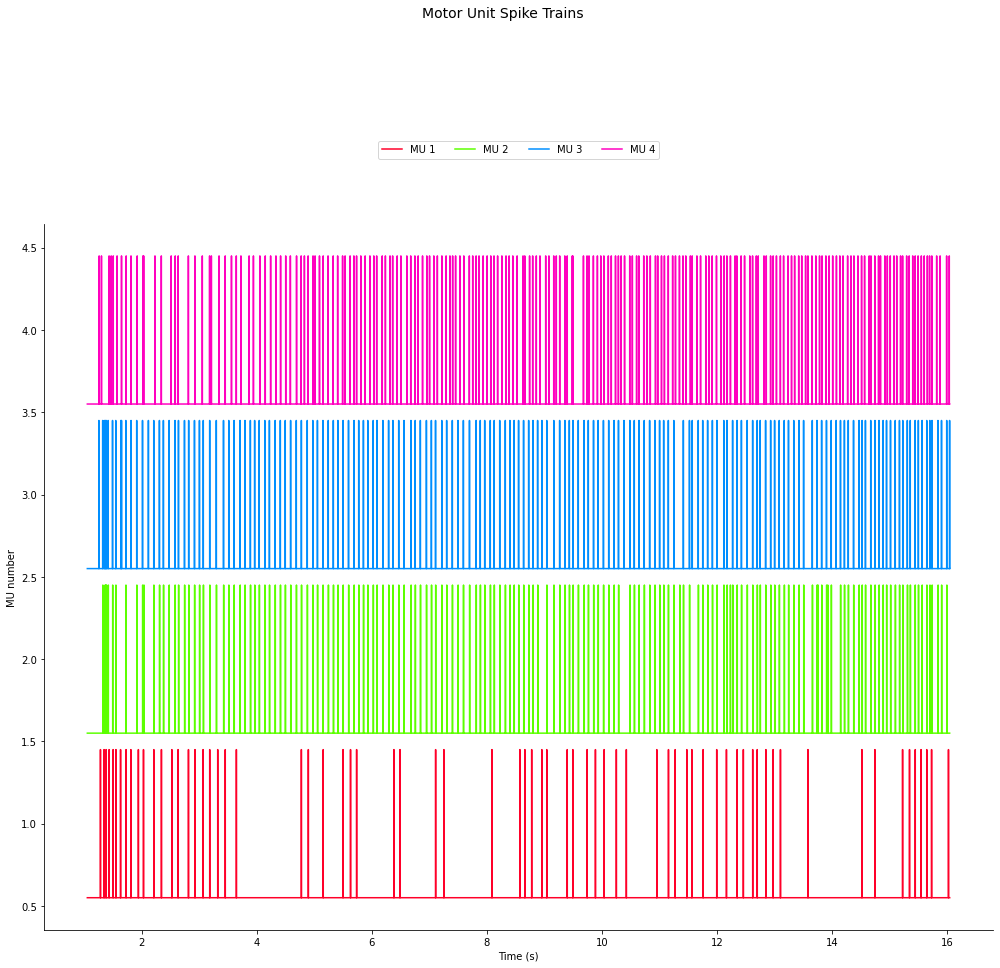

In [8]:
# Plotting spike trains
decomposition.plot_spikes()

### Saving Decomposition Outputs

Now that all metrics are updated, we are going to organize and save them.

1. We create a table to store the SIL measures, PNR values, mean discharge rate, values of the mean, standard deviation, CoV, skewness, and kurtosis of ISIs, and the number of spikes for each estimated spike train. After saving, the file is `Spike_Trains_Metrics.csv`.

2. We create a dictionary that stores the spike trains, estimations of the sources, original HD sEMG signals, a trigger signal, time samples, PNR values, the number of estimated motor units, and the sampling frequency. This dictionary is structured with these specific keys to align with the format used by our `.m` code in the hands-on course 2 for reading decomposition outputs and importing them into the DEMUSE program. After saving, the file is `My_Results_Decomposition.mat`.

3. As the separation matrix and the whitened extended observation matrix are not used by DEMUSE, but are still important, we decided to save them in `Separation_and_Z_Matrices.mat` file.


In [ ]:
# Saving decomposition outputs as .csv and .mat files
decomposition.save_decom_outputs(CoV, Mean, Std, Skewness, Kurtosis)

## Further Reading

To enhance your understanding of EMG decomposition and analysis, we recommend exploring some [additional references](#scrollTo=aditional_references). A valuable starting point is [(DEL VECCHIO; HOLOBAR; FALLA; et al., 2020)](#scrollTo=aditional_references), a didactic paper that provides a step-by-step guide to the decomposition process and emphasizes essential considerations before, during, and after decomposition. While the manual inspection by the operator, as conducted in this workshop and proposed in [(DEL VECCHIO; HOLOBAR; FALLA; et al., 2020)](#scrollTo=aditional_references), may seem subjective, different experienced operators have consistently achieved similar results during manual evaluations [(HUG; AVRILLON; DEL VECCHIO; et al., 2021)](#scrollTo=aditional_references).

Additionally, [ENOKA (2019)](#scrollTo=aditional_references) and [FARINA and HOLOBAR (2016)](#scrollTo=aditional_references) support the application and validation of EMG decomposition techniques for identifying motor unit activities and studying their physiology. In [(HOLOBAR; FARINA, 2014)](#scrollTo=aditional_references), an overview is presented on applying blind source separation to multichannel EMG signals, where you can extract both motor unit discharge times and muscle synergies from the EMG. The section also discusses important considerations when applying BSS techniques to EMG signals.

As we has seen in these notebooks, several parameters require definition for the decomposition algorithm. In the study by [MENG, CHEN, JIANG, et al. (2022)](#scrollTo=aditional_references), various parameters for the FastICA algorithm in decomposing HD sEMG signals were evaluated. The study suggests trade-offs between time consumption and the number of identified motor units. Another established BSS technique and widely utilized for HD sEMG decomposition is the gradient convolution kernel compensation [(HOLOBAR; ZAZULA, 2007)](#scrollTo=aditional_references). Unlike ICA, this technique does not rely on the independence among source signals and does not estimate the separation matrix; instead, it directly estimates motor unit discharge times by maximizing uncorrelation.


## Funding

Part of this project was funded by [CNPq](http://www.cnpq.br/) (Brazilian National Science Foundation): proc. no. 131390/2021-0.

Part of this study was funded by [FAPESP](https://fapesp.br/) (São Paulo Research Foundation): proc. no. 2019/01508-4.

## References

1. HOLOBAR, A.; MINETTO, M. A.; FARINA, D. Accurate identification of motor unit discharge patterns from high-density surface EMG and validation with a novel signal-based performance metric. *Journal of Neural Engineering*, v. 11, n. 1, p. 016008, 2014. DOI: [10.1109/TSP.2007.896108](https://doi.org/10.1109/TSP.2007.896108).

2. HOLOBAR, A.; ZAZULA, D. On the selection of the cost function for gradient-based decomposition of surface electromyograms. *30th Annual International Conference of the IEEE Engineering in Medicine and Biology Society*, Vancouver, BC, Canada, n. 4, p. 4668–4671, 2008. DOI: [10.1109/iembs.2008.4650254](https://doi.org/10.1109/iembs.2008.4650254).

3. HOLOBAR, A.; MINETTO, M. A.; FARINA, D. Experimental Analysis of Accuracy in the Identification of Motor Unit Spike Trains From High-Density Surface EMG. *IEEE Transactions on Neural Systems and Rehabilitation Engineering*, v. 18, n. 3, p. 221–229, 2010. DOI: [10.1109/TNSRE.2010.2041593](https://doi.org/10.1109/TNSRE.2010.2041593).

4. HOLOBAR, A.; ZAZULA, D. Multichannel blind source separation using convolution Kernel compensation. *IEEE Transactions on Signal Processing*, v. 55, n. 9, p. 4487–4496, 2007. DOI: [10.1109/TSP.2007.896108](https://doi.org/10.1109/TSP.2007.896108).

5. HYVÄRINEN, A. Fast and robust fixed-point algorithms for independent component analysis. *IEEE Transactions on Neural Networks*, v. 10, n. 3, p. 626–634, 1999. DOI: [10.1109/72.761722](https://doi.org/10.1109/72.761722).

6. NEGRO, F.; MUCELI, S.; CASTRONOVO, A. M.; et al. Multi-channel intramuscular and surface EMG decomposition by convolutive blind source separation. *Journal of Neural Engineering*, v. 13, n. 2, p. 026027, 2016. DOI: [10.1088/1741-2560/13/2/026027](https://doi.org/10.1088/1741-2560/13/2/026027).

## Aditional References

7. DEL VECCHIO, A.; HOLOBAR, A.; FALLA, D.; et al. Tutorial: Analysis of motor unit discharge characteristics from high-density surface EMG signals. *Journal of Electromyography and Kinesiology*, vol. 53, p. 102426, 2020. DOI: [10.1016/j.jelekin.2020.102426](https://doi.org/10.1016/j.jelekin.2020.102426).

8. ENOKA, R. M. Physiological validation of the decomposition of surface EMG signals. *Journal of Electromyography and Kinesiology*, vol. 46, p. 70-83, 2019. DOI: [10.1016/j.jelekin.2019.03.010](https://doi.org/10.1016/j.jelekin.2019.03.010).

9. FARINA, D.; HOLOBAR, A. Characterization of Human Motor Units From Surface EMG Decomposition. *Proceedings of the IEEE*, vol. 104, no. 2, p. 353-373, 2016. DOI: [10.1109/JPROC.2015.2498665](https://doi.org/10.1109/JPROC.2015.2498665).

10. HOLOBAR, A.; FARINA, D. Blind source identification from the multichannel surface electromyogram. *Physiological Measurement*, vol. 35, no. 7, p. R143--R165, 2014. DOI: [10.1088/0967-3334/35/7/R143](https://doi.org/10.1088/0967-3334/35/7/R143).

11. HOLOBAR, A.; ZAZULA, D. Gradient Convolution Kernel Compensation Applied to Surface Electromyograms. *Independent Component Analysis and Signal Separation, ICA 2007. Lecture Notes in Computer Science*, vol 4666, p. 617–624, 2007. DOI: [10.1007/978-3-540-74494-8_77](https://doi.org/10.1007/978-3-540-74494-8_77).

12. HUG, F.; AVRILLON, S.; DEL VECCHIO, A.; et al. Analysis of motor unit spike trains estimated from high-density surface electromyography is highly reliable across operators. *Journal of Electromyography and Kinesiology*, v. 58, p. 102548, 2021. DOI: [10.1016/j.jelekin.2021.102548](https://doi.org/10.1016/j.jelekin.2021.102548).

13. MENG, L.; CHEN, Q.; JIANG, X.; et al. Evaluation of decomposition parameters for high-density surface electromyogram using fast independent component analysis algorithm. *Biomedical Signal Processing and Control*, v. 75, p. 103615, 2022. DOI: [10.1016/j.bspc.2022.103615](https://doi.org/10.1016/j.bspc.2022.103615).